In [5]:
import numpy as np
import networkx as nx
import geopandas as gpd
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import itertools
from collections import defaultdict

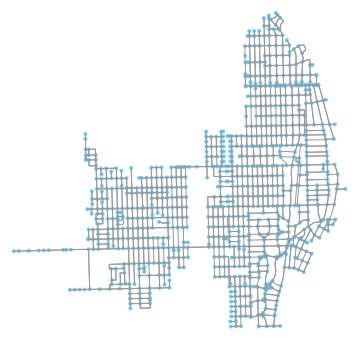

In [33]:
cw = gpd.read_file('497_Data/Wards/chiwards.shp')
cw = cw[pd.notnull(cw['geometry'])]
ward_19 = cw[(cw['ward']=='19')]
polygon = ward_19['geometry'].iloc[0]
gdf = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)
gdf = max(nx.strongly_connected_component_subgraphs(gdf), key=len)
gdf_projected = ox.project_graph(gdf)
fig, ax = ox.plot_graph(gdf)

In [7]:
def get_shortest_paths(graph, pairs, edge_weight_name): #Compute the shortest path between two nodes
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

def add_paths(gdf, nv_paths):
    for path in nv_paths:
        for i in range(len(nv_paths[path])-1): 
            n1 = nv_paths[path][i]
            n2 = nv_paths[path][i+1]
            length1 = gdf[nv_paths[path][i]][nv_paths[path][i+1]][0]['length'] 
            gdf.add_edge(nv_paths[path][i], nv_paths[path][i+1], length=length1, oneway=True) #copy length, oneway, name attributes

def negpos(h1):
    nodes_negative = []
    nodes_positive = []
    for v in h1: 
        diff = h1.out_degree(v)-h1.in_degree(v) 
        if diff<0: 
            for i in range(-diff): 
                nodes_negative.append(v)
                h1.node[v]['degree'] = diff
        elif diff>0: 
            for i in range(diff):
                nodes_positive.append(v)
                h1.node[v]['degree'] = diff
        else: 
                h1.node[v]['degree'] = 0
            
    return nodes_negative, nodes_positive

def wrapper(h1, intFlag=False):
    nneg, npos = negpos(h1)
    nv = list(itertools.product(nneg, npos))
    nv_paths = get_shortest_paths(h1, nv, 'length')
    nv_paths_distances = get_shortest_paths_distances(h1, nv, 'length')
    h_complete = create_complete_graph(h1, nv_paths_distances)
    hd = nx.algorithms.max_weight_matching(h_complete, True)
    new_hd = cleanList(hd, h1, intFlag)
    new_dict = {k: nv_paths[k] for k in new_hd if k in nv_paths}
    h2 = h1.copy()
    add_paths(h2, new_dict)
    return h2

def cleanList(gd, g1, intFlag): 
    newList = []
    for s in gd: 
        degree = nx.get_node_attributes(g1,'degree')
        sep = '_dup'
        if not isinstance(s[0], int): 
            tup0 = s[0].split(sep, 1)[0]
            if(intFlag): 
                tup0 = int(tup0)
        else: 
            tup0 = s[0]
            
        if not isinstance(s[1], int): 
            tup1 = s[1].split(sep, 1)[0]
            if(intFlag): 
                tup1 = int(tup1)
        else: 
            tup1 = s[1]
            
        if degree[tup0]>0: 
            newList.append(tuple((tup1, tup0)))
        else: 
            newList.append(tuple((tup0, tup1)))
    return newList

def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    #distances = defaultdict(list)
    for pair in pairs:
        if pair not in distances: 
            distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
        
        #distances[pair].append(nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name))
    return distances

def create_complete_graph(g1, pair_weights, flip_weights=True): 
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        #rint(k[0])
        
        degree = nx.get_node_attributes(g1,'degree')
        
        deg0= abs(degree[k[0]])
        deg1= abs(degree[k[1]])
        
        if deg0>1: 
            for i in range(deg0): 
                if i==0: 
                    newname = k[0] 
                else: 
                    newname = str(k[0])+'_dup'+str(i)
                g.add_edge(newname, k[1], **{'length': v, 'weight': wt_i}) 
        
        if deg1>1: 
            for i in range(deg1):
                if i==0: 
                    newname = k[1]
                else: 
                    newname = str(k[1])+'_dup'+str(i)
               
                g.add_edge(k[0], newname, **{'length': v, 'weight': wt_i}) 
             
        if deg0<=1 and deg1<=1: 
            g.add_edge(k[0], k[1], **{'length': v, 'weight': wt_i})  
            
    return g

In [2]:
def example_graph1(): 
    g1 = nx.MultiDiGraph()
    g1.add_node('H')
    g1.add_node('I')
    g1.add_node('J')
    g1.add_node('K')
    g1.add_node('L')
    g1.add_node('M')
    g1.add_edge('H', 'I', length=1)
    g1.add_edge('H', 'J', length=4)
    g1.add_edge('J', 'H', length=4)
    g1.add_edge('J', 'K', length=5)
    g1.add_edge('K', 'J', length=5)
    g1.add_edge('I', 'L', length=3)
    g1.add_edge('L', 'I', length=3)
    g1.add_edge('L', 'M', length=2)
    g1.add_edge('M', 'L', length=2)
    g1.add_edge('K', 'M', length=4)
    g1.add_edge('M', 'K', length=4)
    g1.add_edge('K', 'I', length=2)
    node_pos = {'H': (0, 1), 'I': (1, 1),'L': (2,1), 'J': (0,0), 'K': (1,0), 'M': (2,0)}
    #manually create graph G, start reading from here
    nx.draw(g1, pos=node_pos, with_labels = True)
    return wrapper(g1)

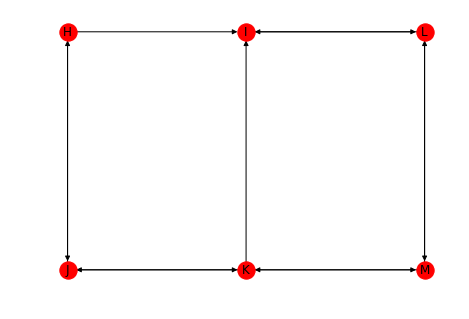

In [8]:
g2 = example_graph1()

In [9]:
list(nx.eulerian_circuit(g2, source='H'))

[('H', 'I'),
 ('I', 'L'),
 ('L', 'M'),
 ('M', 'L'),
 ('L', 'I'),
 ('I', 'L'),
 ('L', 'M'),
 ('M', 'K'),
 ('K', 'I'),
 ('I', 'L'),
 ('L', 'M'),
 ('M', 'K'),
 ('K', 'M'),
 ('M', 'K'),
 ('K', 'J'),
 ('J', 'K'),
 ('K', 'J'),
 ('J', 'H'),
 ('H', 'J'),
 ('J', 'H')]

In [10]:
def example_graph2(): 
    g1 = nx.MultiDiGraph()
    g1.add_node('A')
    g1.add_node('B')
    g1.add_node('C')
    g1.add_node('D')
    g1.add_node('E')
    g1.add_node('F')
    g1.add_node('G')

    g1.add_edge('A', 'B', length=4)
    g1.add_edge('B', 'A', length=5)
    g1.add_edge('A', 'C', length=4)
    g1.add_edge('A', 'D', length=9)
    g1.add_edge('C', 'D', length=6)
    g1.add_edge('D', 'C', length=6)
    g1.add_edge('C', 'F', length=8)
    g1.add_edge('F', 'G', length=4)
    g1.add_edge('G', 'D', length=6)
    g1.add_edge('D', 'E', length=3)
    g1.add_edge('E', 'G', length=5)
    g1.add_edge('E', 'B', length=6)

    node_pos = {'E': (0, 0), 'B': (1, 0),'G': (-.5,1), 'D': (.5,1), 'A': (1.5,1), 'F':(0,2), 'C':(1,2)}
    #manually create graph G, start reading from here
    nx.draw(g1, pos=node_pos, with_labels = True)
    return wrapper(g1)
    #g2 = wrapper(g1)

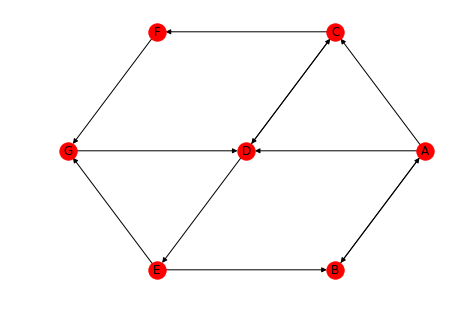

In [11]:
g2 = example_graph2()

In [12]:
list(nx.eulerian_circuit(g2, source='A'))

[('A', 'C'),
 ('C', 'F'),
 ('F', 'G'),
 ('G', 'D'),
 ('D', 'E'),
 ('E', 'G'),
 ('G', 'D'),
 ('D', 'C'),
 ('C', 'D'),
 ('D', 'E'),
 ('E', 'B'),
 ('B', 'A'),
 ('A', 'D'),
 ('D', 'E'),
 ('E', 'B'),
 ('B', 'A'),
 ('A', 'B'),
 ('B', 'A')]

In [321]:
g3 = wrapper(gdf, intFlag=True)

261287949 261287978
261287978 261180628
261155439 261155440
261155440 261155441
261155441 261218396
261218396 261218394
261166208 261223451
261198657 261198655
261198655 717469468
717469468 261225244
261225244 261225225
261225225 261210550
261277469 261158748
261158748 261158749
261158749 261197693
261255641 261194710
261194710 261189410
261189410 261189409
261240790 261191893
261191893 261191894
261191894 261191895
261191895 717469076
261169937 261169936
261169936 261116766
261116766 261116767
261201134 261218898
261218898 261218900
261218900 261161021
261161021 261161025
261319972 261266919
261266919 261142913
261142913 261142925
261142925 261142909
261142909 261319974
261319974 261129470
261129470 261129391
261129391 261129392
261129392 261129394
261129394 1034685844
1034685844 261129395
261213376 261213377
261213377 261160979
261160979 261160978
2876584074 261200114
261200114 261275505
261275505 261180588
261180588 4332527682
261201123 261307511
261307511 261241218
261241218 261129

In [322]:
nx.is_eulerian(g3)

True

We choose our source node to be 261239498, which is on the far left of the graph. 

In [324]:
tour = list(nx.eulerian_circuit(g3, source=261239498))
len(tour)

3067

In [326]:
len(gdf.edges())

2836

In [327]:
len(g3.edges())

3067

In [328]:
list(tour)

[(261239498, 261255623),
 (261255623, 261255625),
 (261255625, 261214742),
 (261214742, 261189609),
 (261189609, 261151733),
 (261151733, 3640013959),
 (3640013959, 261255627),
 (261255627, 5631673242),
 (5631673242, 261169671),
 (261169671, 261211689),
 (261211689, 261211688),
 (261211688, 261281735),
 (261281735, 261316102),
 (261316102, 261198685),
 (261198685, 365231718),
 (365231718, 261198685),
 (261198685, 261316102),
 (261316102, 261192065),
 (261192065, 261174131),
 (261174131, 261135998),
 (261135998, 261135999),
 (261135999, 261243781),
 (261243781, 261243783),
 (261243783, 261135992),
 (261135992, 261135993),
 (261135993, 261135995),
 (261135995, 261135996),
 (261135996, 261174229),
 (261174229, 261135996),
 (261135996, 261243786),
 (261243786, 261243787),
 (261243787, 261116766),
 (261116766, 261243787),
 (261243787, 261174117),
 (261174117, 261316060),
 (261316060, 261281621),
 (261281621, 261303762),
 (261303762, 261291637),
 (261291637, 261249769),
 (261249769, 26116897